In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

# SemTorch
from semtorch import get_segmentation_learner

from pathlib import Path
import random

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
%matplotlib inline
import numpy as np

Function por stablishing the seed for reproducibility

In [3]:
number_of_the_seed = 2020

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
path = Path("../datasets/")
path_images = path/"Images"
path_labels = path/"Labels"

test_name = "test"

Obtaining the label associated with an image, in the case of segmentation it is a mask

In [5]:
get_y_fn = lambda x: Path(str(x).replace("Images","Labels").replace(".png",".tif"))

Aux function for splitting between training and testing

In [6]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

Loading the codes of the different classes. All the datasets have the same codes.

In [7]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

name2id = {v:k for k,v in enumerate(codes)}
print(name2id)
void_code = name2id['Tumor']

def tumour(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

{'NoTumor': 0, 'Tumor': 1}


Early Stopping parameters

In [8]:
monitor_training="valid_loss"
comp_training=np.less

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=2

In [9]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [10]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Flip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=10)
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [11]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 1
        mask[mask==255]=1
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

Definition of the splitter for saying the learner what weights of the network to freeze

In [12]:
def segmentron_splitter(model):
    return [params(model.backbone), params(model.head)]

# DeepLabV3+

## Manual Annotations

In [13]:
manual_name="manual"

In [14]:
path_manual_img = path_images/manual_name
path_manual_lbl = path_labels/manual_name

../datasets/Images/manual/341.png


<AxesSubplot:>

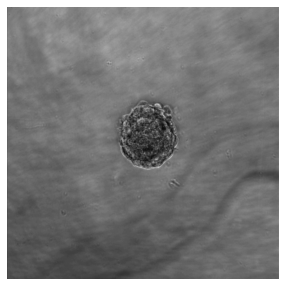

In [15]:
fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

# open and show image
img_f = fnames_manual[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [16]:
print(get_y_fn(img_f))

../datasets/Labels/manual/341.tif


<AxesSubplot:>

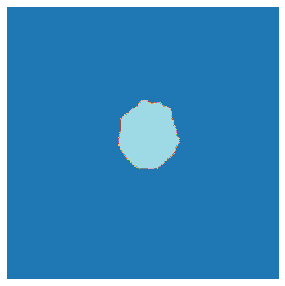

In [17]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [18]:
print(torch.max(image2tensor(mask)))

tensor(255, dtype=torch.uint8)


In [19]:
size = 1002
bs = 2

### No Data Augmentation

#### Hyper-parameter Selection

We are going to adjust weight decay.

Setting-up type transforms pipelines
Found 621 items
2 datasets of sizes 559,62
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual/165.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual/165.png
    applying <lambda> gives
      ../datasets/Labels/manual/165.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Normalize -- {'me

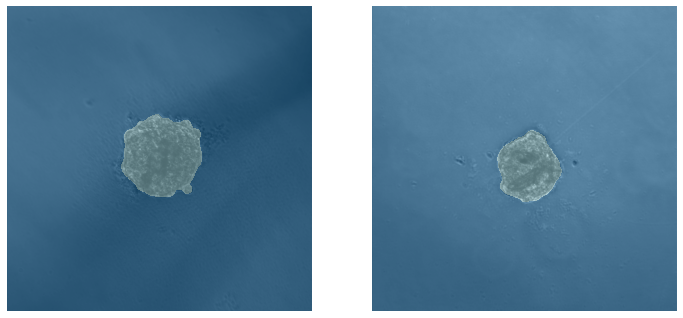

In [20]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_name]),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.1,seed=2020),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform()],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

WD=1e-2

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[tumour, Dice(), JaccardCoeff()],wd=1e-2,
                                 splitter=segmentron_splitter).to_fp16()
learn.freeze() # Freezing the backbone

Recorder

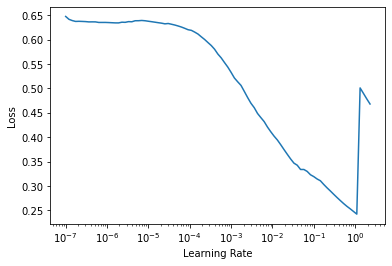

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.043024,0.019144,0.997289,0.951116,0.906788,01:07
1,0.066571,0.078558,0.997165,0.900164,0.818453,01:08
2,0.044439,0.016092,0.996235,0.962426,0.927573,01:08
3,0.023825,0.015644,0.998502,0.959076,0.921370,01:08
4,0.020158,0.012031,0.997100,0.969072,0.940000,01:08
5,0.011396,0.010221,0.997405,0.972282,0.946060,01:08
6,0.013762,0.014257,0.998266,0.963397,0.929379,01:11
7,0.008969,0.011148,0.997358,0.970940,0.943520,01:08


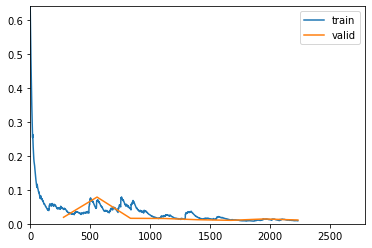

No improvement since epoch 5: early stopping


In [24]:
fname="deeplabv3-segmentron-resnet50-manual-no-data-augmentation-before-unfreeze-WD-2-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(3e-3,3e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("deeplabv3-segmentron-resnet50-manual-no-data-augmentation-before-unfreeze-WD-2-best")
learn.validate()

(#4) [0.010220933705568314,0.997405469417572,0.9722822938496853,0.9460596893788252]

Recorder

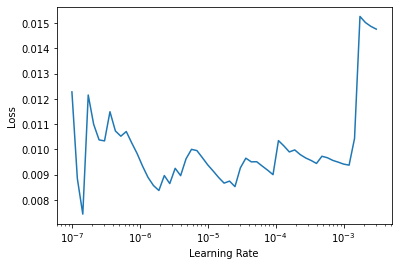

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.010167,0.010490,0.997417,0.971878,0.945294,01:22
1,0.010521,0.010214,0.997727,0.972005,0.945535,01:22
2,0.008921,0.010010,0.997622,0.973048,0.947511,01:22
3,0.009332,0.010237,0.997572,0.972757,0.946959,01:22
4,0.008781,0.010186,0.997872,0.972067,0.945652,01:22


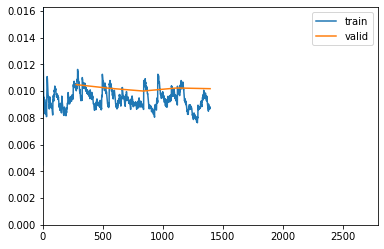

No improvement since epoch 2: early stopping


In [25]:
fname="deeplabv3-segmentron-resnet50-manual-no-data-augmentation-after-unfreeze-WD-2-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(7e-7,2e-6),cbs=callbacksFitAfterUnfreeze)

WD=1e-1

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[tumour, Dice(), JaccardCoeff()],wd=1e-1,
                                 splitter=segmentron_splitter).to_fp16()
learn.freeze() # Freezing the backbone

Recorder

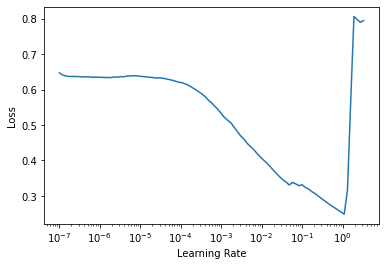

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.039907,0.019934,0.994466,0.949874,0.904533,01:08
1,0.066970,0.039667,0.996046,0.954138,0.912299,01:08
2,0.042189,0.014790,0.996848,0.961469,0.925797,01:08
3,0.022848,0.027382,0.996920,0.938363,0.883884,01:08
4,0.025189,0.013785,0.998761,0.962784,0.928239,01:08
5,0.012798,0.015073,0.998577,0.961932,0.926657,01:08
6,0.012274,0.023755,0.997243,0.957332,0.918157,01:08


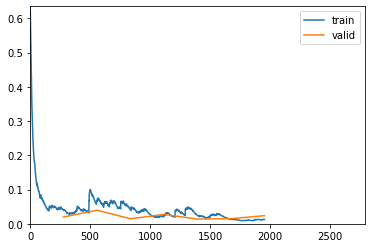

No improvement since epoch 4: early stopping


In [24]:
fname="deeplabv3-segmentron-resnet50-manual-no-data-augmentation-before-unfreeze-WD-1-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(3e-3,3e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("deeplabv3-segmentron-resnet50-manual-no-data-augmentation-before-unfreeze-WD-1-best")
learn.validate()

(#4) [0.013784883543848991,0.9987607002258301,0.9627839201452101,0.928238521215367]

Recorder

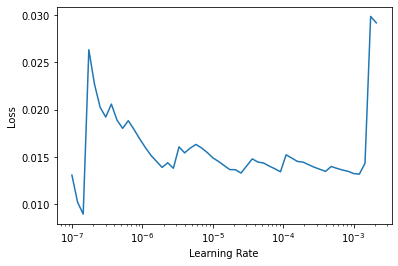

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.017210,0.012420,0.997781,0.966144,0.934506,01:22
1,0.015544,0.012419,0.998502,0.966835,0.935799,01:22
2,0.014529,0.011992,0.998250,0.968591,0.939095,01:22
3,0.013967,0.011854,0.998251,0.969106,0.940064,01:22
4,0.012062,0.012225,0.998624,0.968128,0.938226,01:22
5,0.011914,0.012276,0.998573,0.967888,0.937774,01:22


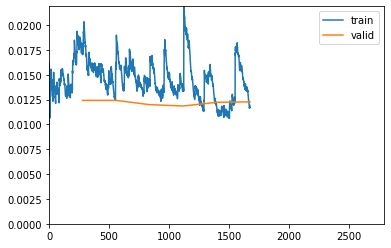

No improvement since epoch 3: early stopping


In [25]:
fname="deeplabv3-segmentron-resnet50-manual-no-data-augmentation-after-unfreeze-WD-1-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(7e-7,2e-6),cbs=callbacksFitAfterUnfreeze)

#### Evaluation - Best hyperparameters

Setting-up type transforms pipelines
Found 987 items
2 datasets of sizes 621,366
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual/416.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual/416.png
    applying <lambda> gives
      ../datasets/Labels/manual/416.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Normalize -- {'m

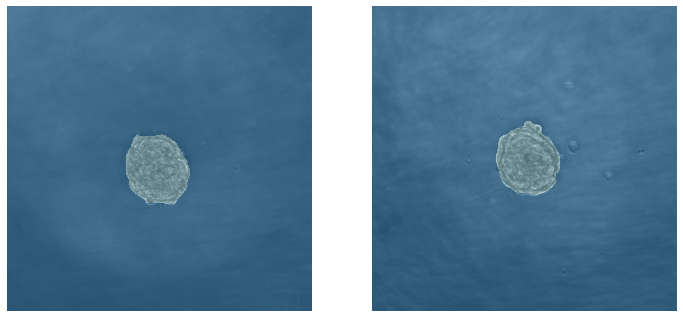

In [20]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_name,test_name]),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform()],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[tumour, Dice(), JaccardCoeff()],wd=1e-2,
                                 splitter=segmentron_splitter).to_fp16()
learn.freeze() # Freezing the backbone

Recorder

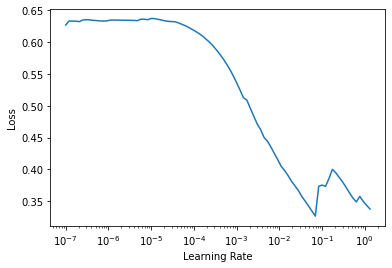

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.041356,0.132699,0.976014,0.782605,0.642853,01:27
1,0.043794,0.053898,0.979865,0.900792,0.819493,01:27
2,0.050908,0.286349,0.921355,0.729578,0.574281,01:27
3,0.019828,0.048620,0.986215,0.907421,0.830532,01:27
4,0.017624,0.038930,0.994860,0.934138,0.876416,01:27
5,0.010729,0.030371,0.996468,0.948846,0.902671,01:27
6,0.010705,0.040852,0.998752,0.931529,0.871834,01:27
7,0.008414,0.026479,0.998190,0.960252,0.923542,01:27
8,0.007654,0.033669,0.997926,0.951366,0.907244,01:27
9,0.007984,0.031161,0.998424,0.954308,0.912609,01:27


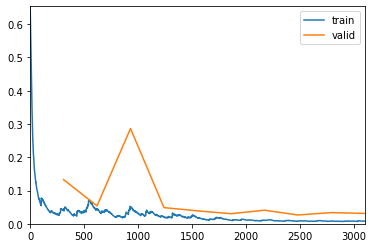

No improvement since epoch 7: early stopping


In [24]:
fname="deeplabv3-segmentron-resnet50-manual-no-data-augmentation-before-unfreeze-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(3e-3,3e-2),cbs=callbacksFitBeforeUnfreeze)

In [23]:
learn.load("deeplabv3-segmentron-resnet50-manual-no-data-augmentation-before-unfreeze-best")
learn.validate()

(#4) [0.026478612795472145,0.9981895685195923,0.960251691990475,0.9235424425251175]

Recorder

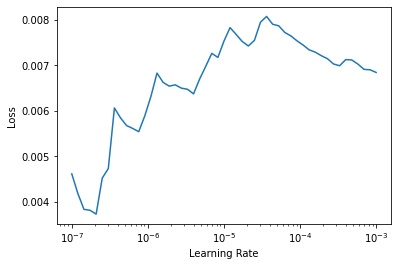

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.008459,0.028997,0.998162,0.957424,0.918325,01:43
1,0.008480,0.029078,0.998533,0.957553,0.918562,01:45
2,0.008100,0.025476,0.998189,0.961986,0.926756,01:43
3,0.007261,0.033053,0.998499,0.953538,0.911201,01:43
4,0.007546,0.027436,0.998015,0.961310,0.925503,01:43


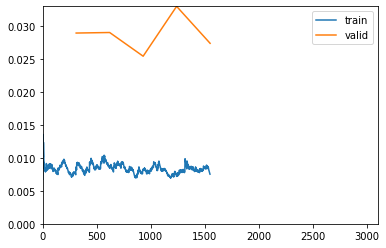

No improvement since epoch 2: early stopping


In [25]:
fname="deeplabv3-segmentron-resnet50-manual-no-data-augmentation-after-unfreeze-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-7,2e-7),cbs=callbacksFitAfterUnfreeze)

In [22]:
learn.load("deeplabv3-segmentron-resnet50-manual-no-data-augmentation-after-unfreeze-best")
learn.validate()

(#4) [0.025475671514868736,0.998188853263855,0.9619856278337807,0.9267555957112857]

In [24]:
aux=learn.model
aux=aux.cpu()

traced_cell=torch.jit.script(aux)
traced_cell.save("TorchScript models/deeplabv3+-dataset1-no-data-augmentation.pth")

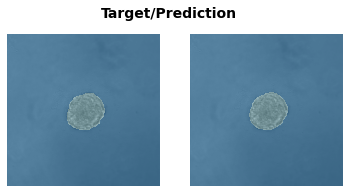

In [41]:
learn.show_results(vmin=0,vmax=1) # show results

### Data Augmentation

Setting-up type transforms pipelines
Found 621 items
2 datasets of sizes 559,62
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual/165.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual/165.png
    applying <lambda> gives
      ../datasets/Labels/manual/165.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> SegmentationAlbumentationsTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255

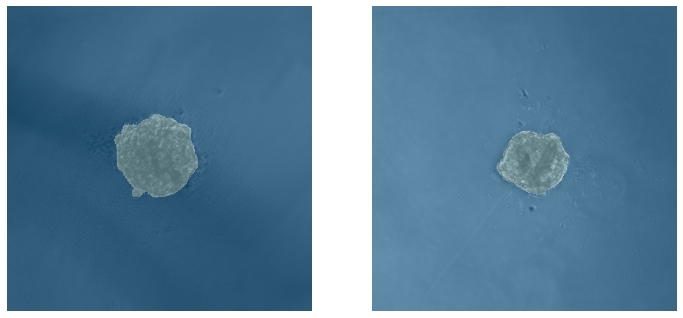

In [20]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_name]),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.1,seed=2020),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                  )
manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

WD=1e-3

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[tumour, Dice(), JaccardCoeff()],wd=1e-3,
                                 splitter=segmentron_splitter).to_fp16()
learn.freeze() # Freezing the backbone

Recorder

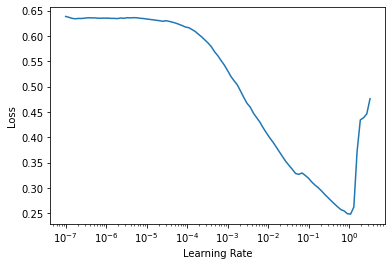

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.050565,0.017572,0.997161,0.956161,0.916004,01:08
1,0.055621,0.050663,0.994781,0.934543,0.877129,01:08
2,0.033952,0.014418,0.996174,0.964017,0.930534,01:08
3,0.036020,0.015082,0.997873,0.954829,0.913563,01:08
4,0.016646,0.014724,0.995741,0.964008,0.930516,01:08


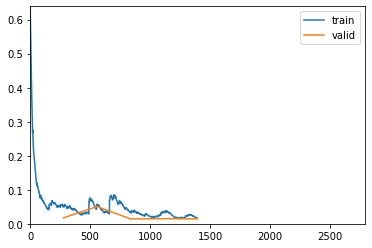

No improvement since epoch 2: early stopping


In [24]:
fname="deeplabv3-segmentron-resnet50-manual-data-augmentation-before-unfreeze-WD-3-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(3e-3,3e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("deeplabv3-segmentron-resnet50-manual-data-augmentation-before-unfreeze-WD-3-best")
learn.validate()

(#4) [0.014417696744203568,0.9961738586425781,0.9640173010416765,0.9305341701275436]

Recorder

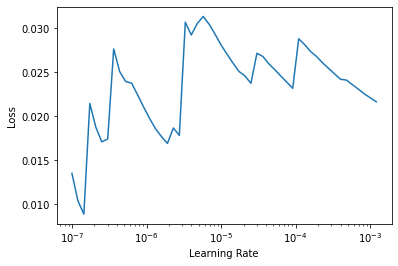

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.027390,0.013742,0.996223,0.964038,0.930573,01:22
1,0.026391,0.013214,0.996365,0.965262,0.932856,01:22
2,0.016196,0.013865,0.995627,0.963610,0.929776,01:22
3,0.020380,0.014710,0.995175,0.961477,0.925811,01:22


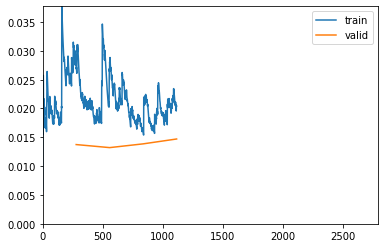

No improvement since epoch 1: early stopping


In [25]:
fname="deeplabv3-segmentron-resnet50-manual-data-augmentation-after-unfreeze-WD-3-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(4e-7,2e-6),cbs=callbacksFitAfterUnfreeze)

WD=1e-2

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[tumour, Dice(), JaccardCoeff()],wd=1e-2,
                                 splitter=segmentron_splitter).to_fp16()
learn.freeze() # Freezing the backbone

Recorder

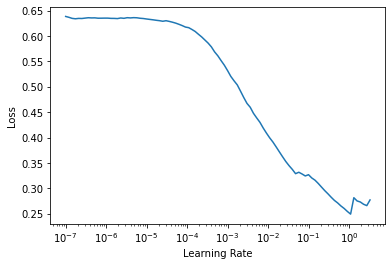

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.044047,0.031244,0.990499,0.936881,0.881258,01:08
1,0.056711,0.043612,0.998869,0.941706,0.889835,01:08
2,0.043162,0.015541,0.995782,0.958364,0.920056,01:08
3,0.029813,0.053873,0.980428,0.879025,0.784162,01:08
4,0.021464,0.015791,0.995804,0.962062,0.926897,01:08


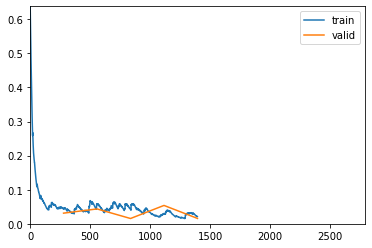

No improvement since epoch 2: early stopping


In [24]:
fname="deeplabv3-segmentron-resnet50-manual-data-augmentation-before-unfreeze-WD-2-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(3e-3,3e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("deeplabv3-segmentron-resnet50-manual-data-augmentation-before-unfreeze-WD-2-best")
learn.validate()

(#4) [0.015540855936706066,0.9957823157310486,0.9583638578916622,0.9200562645146634]

Recorder

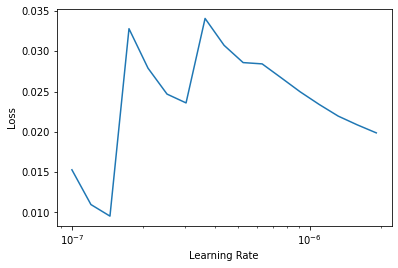

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.044444,0.015594,0.996143,0.958138,0.919641,01:22
1,0.053035,0.015546,0.996567,0.958421,0.920162,01:22
2,0.025157,0.015342,0.996102,0.958762,0.920791,01:22
3,0.032872,0.015517,0.995742,0.958745,0.920760,01:22
4,0.033474,0.015261,0.996209,0.959001,0.921232,01:22
5,0.024504,0.015239,0.996398,0.958895,0.921035,01:22
6,0.036886,0.015184,0.996280,0.958619,0.920527,01:22
7,0.024552,0.014986,0.996222,0.959265,0.921719,01:22
8,0.028121,0.015333,0.996044,0.958861,0.920973,01:22
9,0.025494,0.014467,0.996446,0.960302,0.923636,01:22


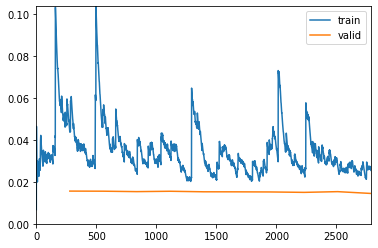

In [25]:
fname="deeplabv3-segmentron-resnet50-manual-data-augmentation-after-unfreeze-WD-2-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(7e-7,2e-6),cbs=callbacksFitAfterUnfreeze)

WD=1e-1

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[tumour, Dice(), JaccardCoeff()],wd=1e-1,
                                 splitter=segmentron_splitter).to_fp16()
learn.freeze() # Freezing the backbone

Recorder

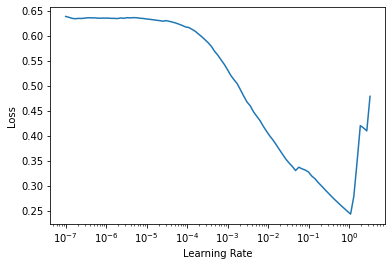

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.046105,0.024222,0.992846,0.940536,0.887748,01:08
1,0.065342,0.033645,0.997849,0.925000,0.860466,01:08
2,0.063595,0.017496,0.996401,0.955894,0.915515,01:08
3,0.026205,0.015522,0.995792,0.962769,0.928212,01:08
4,0.028822,0.018847,0.995235,0.958621,0.920531,01:08
5,0.013973,0.014049,0.996537,0.962677,0.928040,01:08
6,0.018832,0.014366,0.996823,0.963441,0.929461,01:08
7,0.011646,0.011647,0.997145,0.969374,0.940568,01:08
8,0.009268,0.013300,0.998107,0.967280,0.936633,01:10
9,0.008986,0.010502,0.998032,0.971812,0.945171,01:08


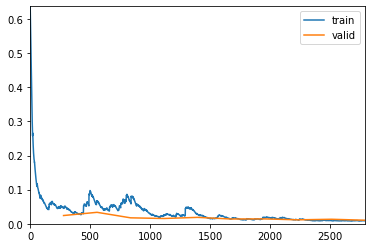

In [24]:
fname="deeplabv3-segmentron-resnet50-manual-data-augmentation-before-unfreeze-WD-1-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(3e-3,3e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("deeplabv3-segmentron-resnet50-manual-data-augmentation-before-unfreeze-WD-1-best")
learn.validate()

(#4) [0.010502127930521965,0.9980316162109375,0.9718124971051054,0.945170500875508]

Recorder

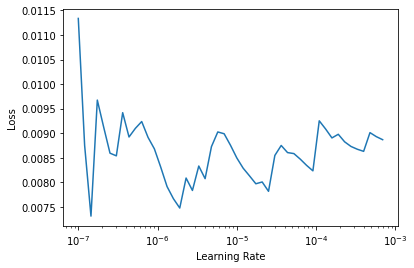

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.009729,0.010580,0.997903,0.971852,0.945246,01:22
1,0.009666,0.010194,0.998037,0.972384,0.946252,01:22
2,0.009114,0.010211,0.997873,0.972748,0.946941,01:22
3,0.008691,0.010189,0.998025,0.972460,0.946397,01:22
4,0.008895,0.010676,0.998076,0.971434,0.944454,01:22
5,0.008395,0.011191,0.998247,0.971233,0.944074,01:22


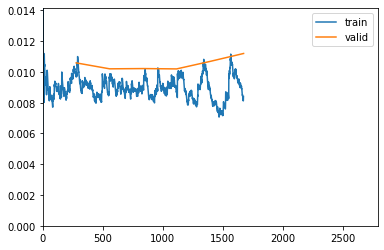

No improvement since epoch 3: early stopping


In [25]:
fname="deeplabv3-segmentron-resnet50-manual-data-augmentation-after-unfreeze-WD-1-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(7e-7,2e-6),cbs=callbacksFitAfterUnfreeze)

#### Evaluation - Best hyperparameters

Setting-up type transforms pipelines
Found 987 items
2 datasets of sizes 621,366
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual/416.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual/416.png
    applying <lambda> gives
      ../datasets/Labels/manual/416.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> SegmentationAlbumentationsTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 25

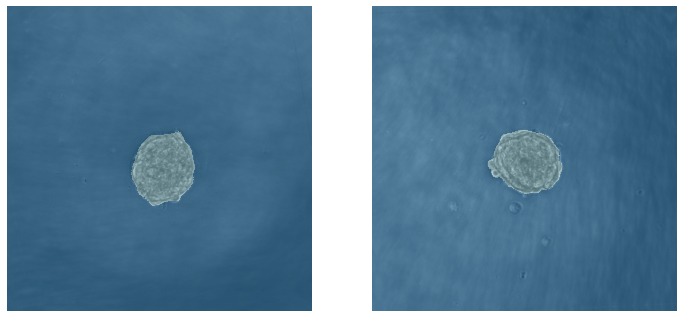

In [20]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_name,test_name]),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                  )
manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[tumour, Dice(), JaccardCoeff()],wd=1e-2,
                                 splitter=segmentron_splitter).to_fp16()
learn.freeze() # Freezing the backbone

Recorder

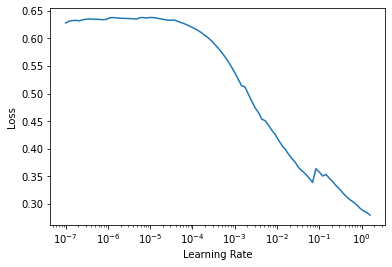

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.041243,0.086431,0.965552,0.835513,0.717495,01:27
1,0.046964,0.064392,0.981400,0.888960,0.800116,01:27
2,0.035309,0.038930,0.989048,0.935218,0.878319,01:27
3,0.017488,0.035564,0.989318,0.933679,0.875609,01:27
4,0.020062,0.033016,0.996198,0.939915,0.886641,01:27
5,0.013224,0.021849,0.997707,0.960447,0.923904,01:27
6,0.013403,0.026727,0.996823,0.949481,0.903821,01:27
7,0.009393,0.021416,0.997867,0.961279,0.925445,01:27
8,0.008475,0.030129,0.998102,0.955234,0.914304,01:27
9,0.009359,0.026324,0.998264,0.958207,0.919766,01:27


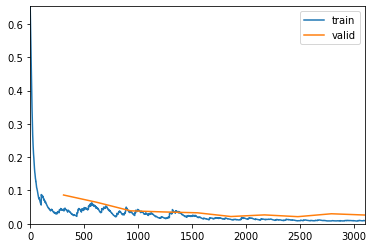

No improvement since epoch 7: early stopping


In [24]:
fname="deeplabv3-segmentron-resnet50-manual-data-augmentation-before-unfreeze-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(3e-3,3e-2),cbs=callbacksFitBeforeUnfreeze)

In [23]:
learn.load("deeplabv3-segmentron-resnet50-manual-data-augmentation-before-unfreeze-best")
learn.validate()

(#4) [0.021415645256638527,0.9978670477867126,0.9612793430697916,0.9254454859025489]

In [24]:
aux=learn.model
aux=aux.cpu()

traced_cell=torch.jit.script(aux)
traced_cell.save("TorchScript models/deeplabv3+-dataset1-data-augmentation.pth")

Recorder

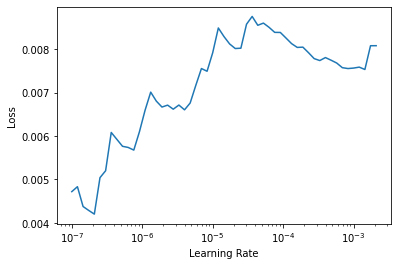

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.012523,0.022618,0.997958,0.959692,0.922507,01:43
1,0.009400,0.021438,0.998063,0.960960,0.924854,01:43
2,0.009939,0.021050,0.997819,0.961215,0.925326,01:43
3,0.009052,0.023983,0.997786,0.957143,0.917809,01:44
4,0.009467,0.023904,0.997842,0.958322,0.919980,01:43


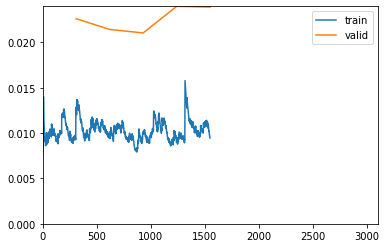

No improvement since epoch 2: early stopping


In [25]:
fname="deeplabv3-segmentron-resnet50-manual-data-augmentation-after-unfreeze-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-7,2e-7),cbs=callbacksFitAfterUnfreeze)

In [22]:
learn.load("deeplabv3-segmentron-resnet50-manual-data-augmentation-after-unfreeze-best")
learn.validate()

(#4) [0.02104964107275009,0.997818648815155,0.9612151352920043,0.9253264732175355]

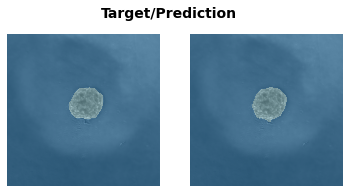

In [28]:
learn.show_results(vmin=0,vmax=1) # show results

## Manual + SpheroidJ Annotations

In [13]:
manual_spheroidj_name = "manual + spheroidj"

In [14]:
path_manual_plus_spheroidj_clear_img = path_images/manual_spheroidj_name
path_manual_plus_spheroidj_clear_lbl = path_labels/manual_spheroidj_name

../datasets/Images/manual + spheroidj/805.png


<AxesSubplot:>

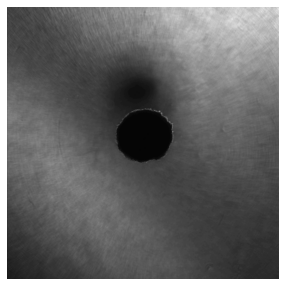

In [15]:
fnames_manual_plus_spheroidj_clear = get_image_files(path_manual_plus_spheroidj_clear_img)
lbl_names_manual_plus_spheroidj_clear = get_image_files(path_manual_plus_spheroidj_clear_lbl)

# open and show image
img_f = fnames_manual_plus_spheroidj_clear[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [16]:
print(get_y_fn(img_f))

../datasets/Labels/manual + spheroidj/805.tif


<AxesSubplot:>

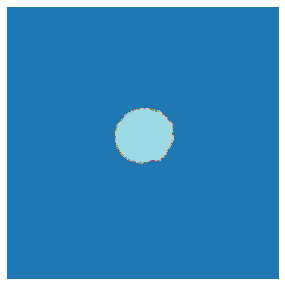

In [17]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [18]:
print(torch.max(image2tensor(mask)))

tensor(255, dtype=torch.uint8)


In [19]:
size = 1002
bs = 2

### No Data Augmentation

Setting-up type transforms pipelines
Found 1069 items
2 datasets of sizes 963,106
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/42.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/42.png
    applying <lambda> gives
      ../datasets/Labels/manual + spheroidj/42.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 

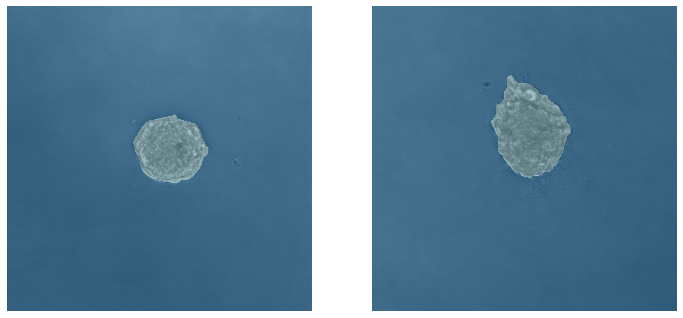

In [20]:
manual_spheroidj_clear = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_spheroidj_name]),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.1,seed=2020),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform()],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
manual_spheroidj_clear.summary(path_images)
dls = manual_spheroidj_clear.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

WD=1e-4

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[tumour, Dice(), JaccardCoeff()],wd=1e-4,
                                 splitter=segmentron_splitter).to_fp16()
learn.freeze() # Freezing the backbone

Recorder

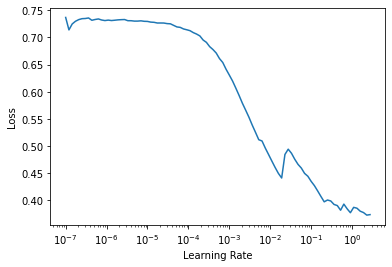

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.021644,0.054916,0.981968,0.922145,0.855538,01:55
1,0.025611,0.022037,0.995066,0.962390,0.927507,01:55
2,0.027321,0.028791,0.990420,0.947690,0.900580,01:56
3,0.017155,0.028783,0.990426,0.949870,0.904526,01:56


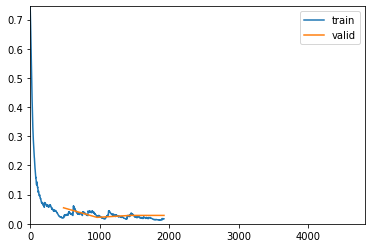

No improvement since epoch 1: early stopping


In [24]:
fname="deeplabv3-segmentron-resnet50-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-4-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("deeplabv3-segmentron-resnet50-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-4-best")
learn.validate()

(#4) [0.022036734968423843,0.9950663447380066,0.9623904350645631,0.9275072894344858]

Recorder

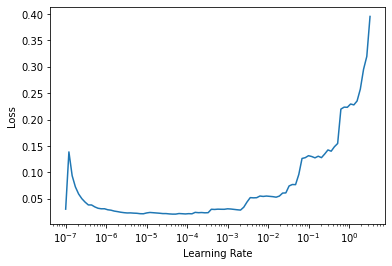

In [24]:
learn.unfreeze()
learn.lr_find(stop_div=False) # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.014077,0.022717,0.994398,0.962332,0.927399,02:20
1,0.013272,0.021529,0.995062,0.962333,0.927401,02:20
2,0.014119,0.019991,0.994870,0.964251,0.930970,02:20
3,0.017141,0.016438,0.996312,0.970106,0.941946,02:21
4,0.020060,0.018052,0.995768,0.967234,0.936546,02:21
5,0.017744,0.016605,0.996429,0.970924,0.943492,02:21


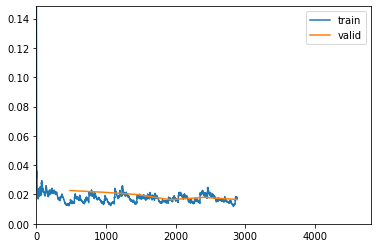

No improvement since epoch 3: early stopping


In [25]:
fname="deeplabv3-segmentron-resnet50-manual-spheroidj-no-data-augmentation-after-unfreeze-WD-4-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(2e-7,2e-6),cbs=callbacksFitAfterUnfreeze)

WD=1e-3

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[tumour, Dice(), JaccardCoeff()],wd=1e-3,
                                 splitter=segmentron_splitter).to_fp16()
learn.freeze() # Freezing the backbone

Recorder

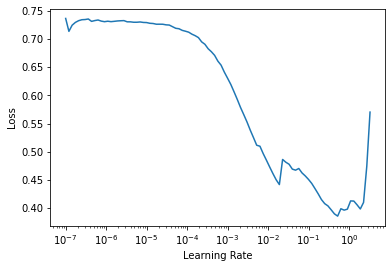

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.022154,0.076743,0.974837,0.898785,0.816175,01:56
1,0.023763,0.035357,0.989771,0.941642,0.889719,01:56
2,0.026776,0.134424,0.999056,0.887980,0.798529,01:56
3,0.015816,0.014269,0.998423,0.972674,0.946801,01:56
4,0.015429,0.016225,0.997565,0.973801,0.948939,01:56
5,0.012153,0.011304,0.996781,0.978613,0.958121,01:56
6,0.010998,0.012038,0.998267,0.978320,0.957561,01:56
7,0.010723,0.010913,0.997753,0.980507,0.961759,01:56
8,0.009051,0.012264,0.998152,0.976645,0.954356,01:56
9,0.007710,0.011756,0.998450,0.977187,0.955392,01:56


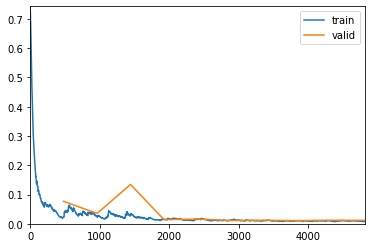

No improvement since epoch 7: early stopping


In [24]:
fname="deeplabv3-segmentron-resnet50-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-3-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("deeplabv3-segmentron-resnet50-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-3-best")
learn.validate()

(#4) [0.010912967845797539,0.9977532029151917,0.9805069391708872,0.9617593065061966]

Recorder

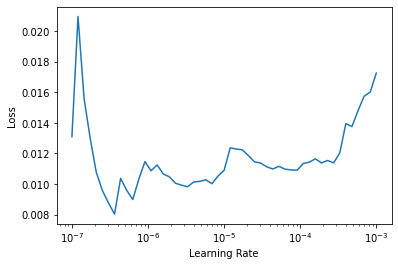

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.008423,0.011768,0.997879,0.977432,0.955861,02:20
1,0.009780,0.014878,0.998023,0.972914,0.947257,02:20
2,0.008630,0.011453,0.998246,0.978269,0.957463,02:20
3,0.009645,0.011345,0.998420,0.979008,0.958878,02:20
4,0.010354,0.011171,0.998056,0.979569,0.959956,02:20
5,0.009799,0.010380,0.997907,0.980914,0.962542,02:20
6,0.009478,0.016162,0.998472,0.970979,0.943595,02:20
7,0.010122,0.010935,0.998095,0.980328,0.961416,02:20


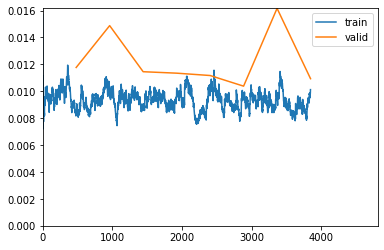

No improvement since epoch 5: early stopping


In [25]:
fname="deeplabv3-segmentron-resnet50-manual-spheroidj-no-data-augmentation-after-unfreeze-WD-3-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(2e-7,3e-7),cbs=callbacksFitAfterUnfreeze)

WD=1e-2

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[tumour, Dice(), JaccardCoeff()],wd=1e-2,
                                 splitter=segmentron_splitter).to_fp16()
learn.freeze() # Freezing the backbone

Recorder

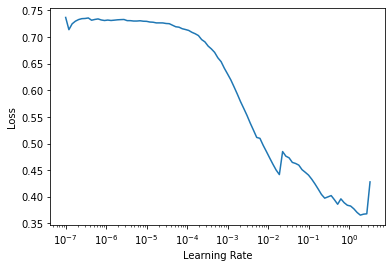

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.021221,0.072172,0.976661,0.901744,0.821068,01:56
1,0.023348,0.039364,0.992292,0.916806,0.846391,01:56
2,0.018682,0.014887,0.998739,0.970702,0.943072,01:56
3,0.016262,0.013781,0.997891,0.974018,0.949352,01:56
4,0.015793,0.012109,0.997670,0.977967,0.956884,01:56
5,0.012973,0.011840,0.996675,0.977606,0.956193,01:55
6,0.012019,0.012778,0.998411,0.975555,0.952277,01:55
7,0.011188,0.009955,0.998176,0.981385,0.963450,01:56
8,0.008997,0.009789,0.997932,0.981333,0.963349,01:56
9,0.007720,0.009849,0.998177,0.980946,0.962604,01:56


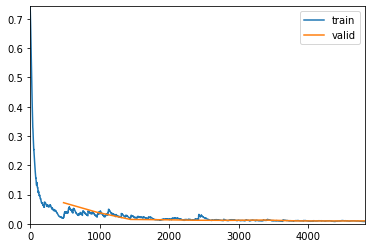

In [24]:
fname="deeplabv3-segmentron-resnet50-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-2-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("deeplabv3-segmentron-resnet50-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-2-best")
learn.validate()

(#4) [0.009789098054170609,0.9979317784309387,0.9813325761324752,0.9633493259327934]

Recorder

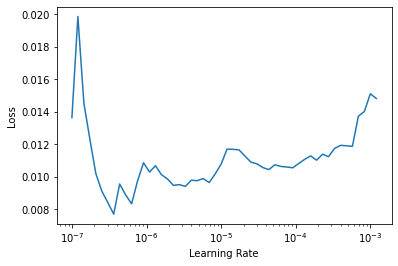

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.008236,0.009940,0.997791,0.980781,0.962286,02:20
1,0.009416,0.010382,0.997883,0.979681,0.960172,02:21
2,0.008496,0.010093,0.998120,0.980398,0.961549,02:21


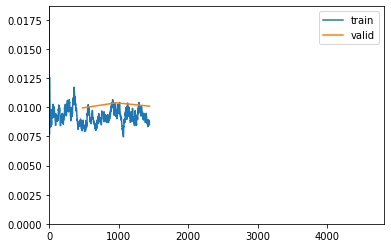

No improvement since epoch 0: early stopping


In [25]:
fname="deeplabv3-segmentron-resnet50-manual-spheroidj-no-data-augmentation-after-unfreeze-WD-2-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(2e-7,3e-7),cbs=callbacksFitAfterUnfreeze)

WD=1e-1

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[tumour, Dice(), JaccardCoeff()],wd=1e-1,
                                 splitter=segmentron_splitter).to_fp16()
learn.freeze() # Freezing the backbone

SuggestedLRs(lr_min=0.19054607152938843, lr_steep=0.0030199517495930195)


Recorder

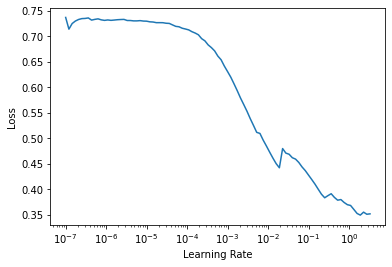

In [23]:
print(learn.lr_find()) # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.022409,0.045389,0.984977,0.931425,0.871651,01:57
1,0.025548,0.026299,0.993208,0.949465,0.903792,01:56
2,0.019853,0.017086,0.997949,0.968653,0.939211,01:56
3,0.018077,0.027861,0.998703,0.951933,0.908275,01:56
4,0.018476,0.018048,0.994951,0.970274,0.942264,01:56


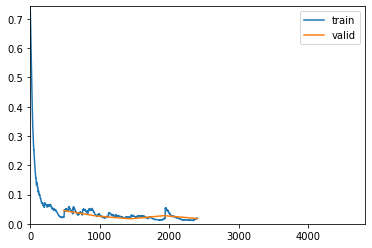

No improvement since epoch 2: early stopping


In [24]:
fname="deeplabv3-segmentron-resnet50-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-1-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("deeplabv3-segmentron-resnet50-manual-spheroidj-no-data-augmentation-before-unfreeze-WD-1-best")
learn.validate()

(#4) [0.017086412757635117,0.9979486465454102,0.9686527067525754,0.9392109845972045]

Recorder

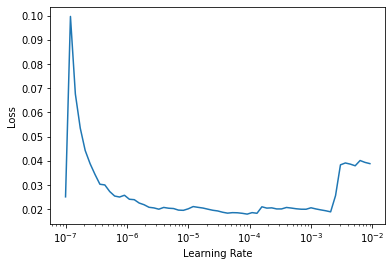

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.013339,0.017435,0.997743,0.967706,0.937433,02:20
1,0.014828,0.016994,0.997553,0.968998,0.939860,02:21
2,0.011974,0.013924,0.997611,0.974578,0.950417,02:21
3,0.020381,0.012180,0.997443,0.977032,0.955096,02:21
4,0.017533,0.013329,0.997512,0.975307,0.951805,02:21
5,0.016539,0.012229,0.997461,0.977216,0.955448,02:21


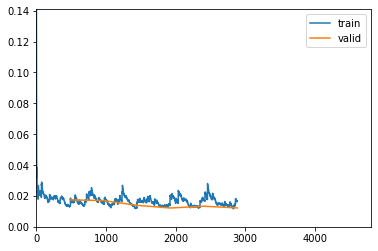

No improvement since epoch 3: early stopping


In [25]:
fname="deeplabv3-segmentron-resnet50-manual-spheroidj-no-data-augmentation-after-unfreeze-WD-1-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(2e-7,3e-6),cbs=callbacksFitAfterUnfreeze)

#### Evaluation - Best hyperparameters

Setting-up type transforms pipelines
Found 1435 items
2 datasets of sizes 1069,366
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/416.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/416.png
    applying <lambda> gives
      ../datasets/Labels/manual + spheroidj/416.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255

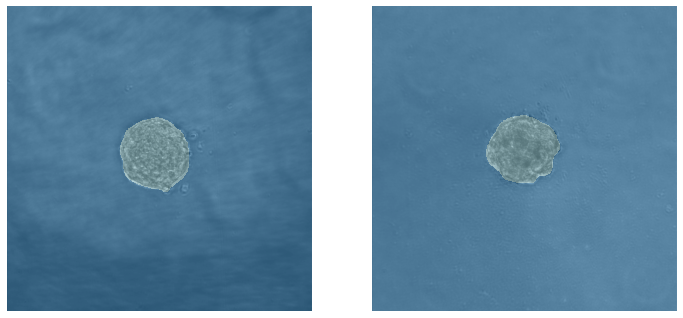

In [20]:
manual_spheroidj_clear = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                                     get_items=partial(get_image_files,folders=[manual_spheroidj_name,test_name]),
                                     get_y=get_y_fn,
                                     splitter=FuncSplitter(ParentSplitter),
                                     item_tfms=[Resize((size,size)), TargetMaskConvertTransform()],
                                     batch_tfms=Normalize.from_stats(*imagenet_stats)
                          )
manual_spheroidj_clear.summary(path_images)
dls = manual_spheroidj_clear.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[tumour, Dice(), JaccardCoeff()],wd=1e-2,
                                 splitter=segmentron_splitter).to_fp16()
learn.freeze() # Freezing the backbone

Recorder

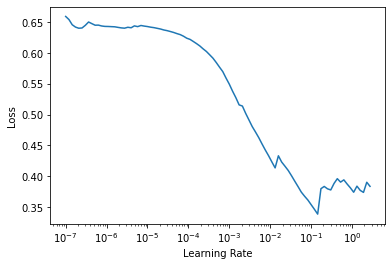

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.042923,0.034593,0.989773,0.943552,0.893136,02:18
1,0.019346,0.021209,0.995390,0.961004,0.924936,02:19
2,0.019920,0.022938,0.995429,0.960097,0.923256,02:19
3,0.015968,0.025911,0.990755,0.948559,0.902151,02:19


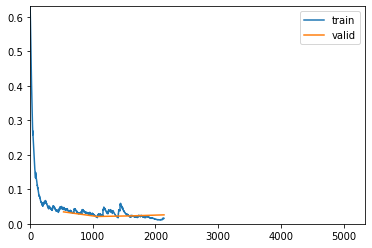

No improvement since epoch 1: early stopping


In [24]:
fname="deeplabv3-segmentron-resnet50-manual-spheroidj-no-data-augmentation-before-unfreeze-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2),cbs=callbacksFitBeforeUnfreeze)

In [23]:
learn.load("deeplabv3-segmentron-resnet50-manual-spheroidj-no-data-augmentation-before-unfreeze-best")
learn.validate()

(#4) [0.021208755671977997,0.995389997959137,0.961004200191588,0.9249355968222341]

Recorder

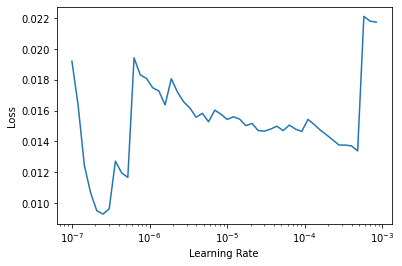

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.023489,0.097932,0.998499,0.824424,0.701293,02:45
1,0.014278,0.020269,0.994770,0.964928,0.932233,02:47
2,0.016494,0.030168,0.997271,0.954366,0.912714,02:47
3,0.013736,0.018187,0.994551,0.966013,0.934259,02:47
4,0.012315,0.016391,0.997913,0.968915,0.939705,02:47
5,0.009893,0.014404,0.996899,0.973255,0.947903,02:47
6,0.009525,0.018104,0.997830,0.968995,0.939855,02:47
7,0.008651,0.014709,0.997451,0.973523,0.948413,02:47
8,0.009308,0.014721,0.997620,0.973040,0.947496,02:47
9,0.008997,0.013896,0.997127,0.974487,0.950243,02:47


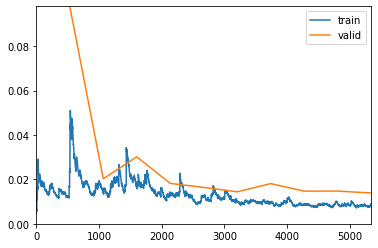

In [25]:
fname="deeplabv3-segmentron-resnet50-manual-spheroidj-no-data-augmentation-after-unfreeze-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(2e-6,3e-6),cbs=callbacksFitAfterUnfreeze)

In [22]:
learn.load("deeplabv3-segmentron-resnet50-manual-spheroidj-no-data-augmentation-after-unfreeze-best")
learn.validate()

(#4) [0.013896063901484013,0.9971272349357605,0.9744870237492964,0.9502434843019157]

In [24]:
aux=learn.model
aux=aux.cpu()

traced_cell=torch.jit.script(aux)
traced_cell.save("TorchScript models/deeplabv3+-dataset3-no-data-augmentation.pth")

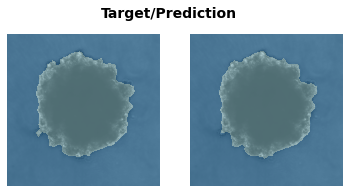

In [30]:
learn.show_results(vmin=0,vmax=1) # show results

### DataAugmentation

Setting-up type transforms pipelines
Found 1069 items
2 datasets of sizes 963,106
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/42.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/42.png
    applying <lambda> gives
      ../datasets/Labels/manual + spheroidj/42.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> SegmentationAlbumentationsTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeli

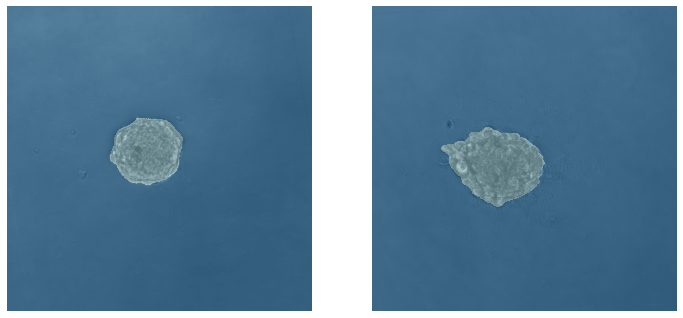

In [20]:
manual_spheroidj_clear = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_spheroidj_name]),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.1,seed=2020),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                  )
manual_spheroidj_clear.summary(path_images)
dls = manual_spheroidj_clear.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

WD=1e-4

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[tumour, Dice(), JaccardCoeff()],wd=1e-4,
                                 splitter=segmentron_splitter).to_fp16()
learn.freeze() # Freezing the backbone

Recorder

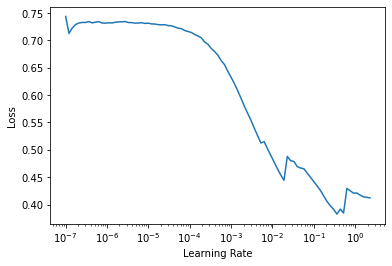

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.024143,0.054457,0.979993,0.916594,0.846030,01:57
1,0.029101,0.026950,0.991339,0.955143,0.914137,01:57
2,0.019927,0.015458,0.997319,0.971533,0.944642,02:04
3,0.015431,0.013496,0.996548,0.974175,0.949650,02:03
4,0.017787,0.012503,0.997769,0.975382,0.951947,02:04
5,0.015274,0.012745,0.996904,0.977937,0.956826,02:01
6,0.015241,0.019417,0.997385,0.961981,0.926746,02:00


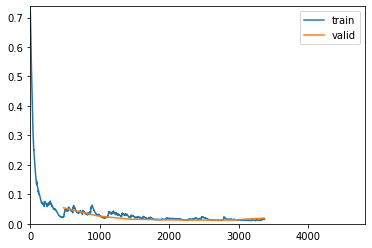

No improvement since epoch 4: early stopping


In [24]:
fname="deeplabv3-segmentron-resnet50-manual-spheroidj-data-augmentation-before-unfreeze-WD-4-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("deeplabv3-segmentron-resnet50-manual-spheroidj-data-augmentation-before-unfreeze-WD-4-best")
learn.validate()

(#4) [0.012502730824053288,0.9977688789367676,0.9753820264197154,0.9519470198355725]

Recorder

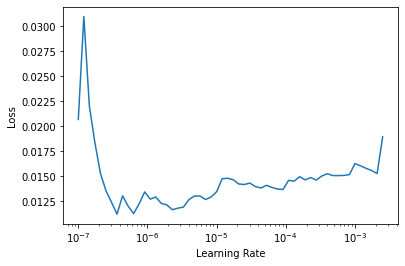

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.010867,0.012942,0.997899,0.974313,0.949912,02:25
1,0.013573,0.013076,0.997266,0.975072,0.951357,02:23
2,0.011285,0.012010,0.997429,0.976385,0.953860,02:37
3,0.013088,0.011769,0.997808,0.977300,0.955608,02:25
4,0.013513,0.011549,0.998020,0.977669,0.956314,02:22
5,0.012471,0.011324,0.997500,0.978364,0.957644,02:23
6,0.013903,0.011636,0.997893,0.977516,0.956022,02:23
7,0.013731,0.011718,0.998176,0.977659,0.956294,02:23


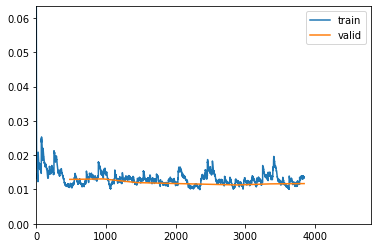

No improvement since epoch 5: early stopping


In [25]:
fname="deeplabv3-segmentron-resnet50-manual-spheroidj-data-augmentation-after-unfreeze-WD-4-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(2e-7,3e-7),cbs=callbacksFitAfterUnfreeze)

WD=1e-3

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[tumour, Dice(), JaccardCoeff()],wd=1e-3,
                                 splitter=segmentron_splitter).to_fp16()
learn.freeze() # Freezing the backbone

Recorder

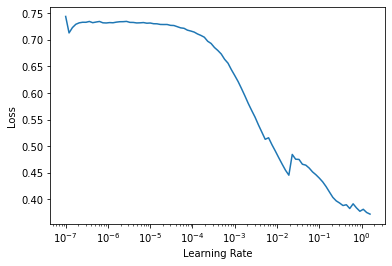

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.024304,0.040276,0.988269,0.935111,0.878130,01:56
1,0.026064,0.022634,0.992787,0.955811,0.915362,01:56
2,0.021863,0.017167,0.995773,0.968078,0.938130,01:56
3,0.016227,0.014141,0.997338,0.975114,0.951437,01:57
4,0.019357,0.012625,0.997429,0.977380,0.955760,01:57
5,0.014921,0.014660,0.995458,0.972632,0.946723,01:57
6,0.014501,0.013054,0.997193,0.977218,0.955450,01:57


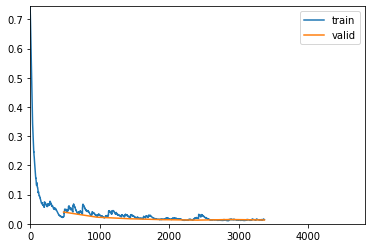

No improvement since epoch 4: early stopping


In [24]:
fname="deeplabv3-segmentron-resnet50-manual-spheroidj-data-augmentation-before-unfreeze-WD-3-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("deeplabv3-segmentron-resnet50-manual-spheroidj-data-augmentation-before-unfreeze-WD-3-best")
learn.validate()

(#4) [0.012624953873455524,0.9974286556243896,0.9773798424509607,0.955760391809107]

Recorder

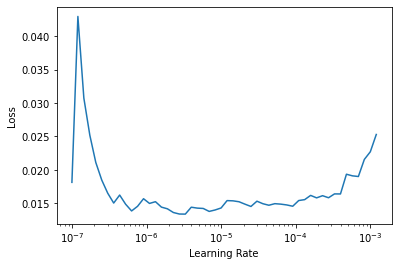

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.012724,0.013084,0.997643,0.976113,0.953341,02:30
1,0.013186,0.012776,0.996980,0.976010,0.953145,02:30
2,0.011702,0.012616,0.997385,0.977295,0.955599,02:31
3,0.013293,0.012162,0.997355,0.977980,0.956908,02:31
4,0.014543,0.012425,0.997817,0.977082,0.955191,02:28
5,0.013099,0.012943,0.996751,0.976014,0.953152,02:23


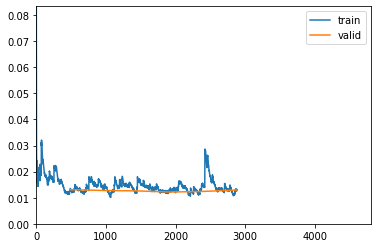

No improvement since epoch 3: early stopping


In [25]:
fname="deeplabv3-segmentron-resnet50-manual-spheroidj-data-augmentation-after-unfreeze-WD-3-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(2e-7,3e-7),cbs=callbacksFitAfterUnfreeze)

WD=1e-2

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[tumour, Dice(), JaccardCoeff()],wd=1e-2,
                                 splitter=segmentron_splitter).to_fp16()
learn.freeze() # Freezing the backbone

Recorder

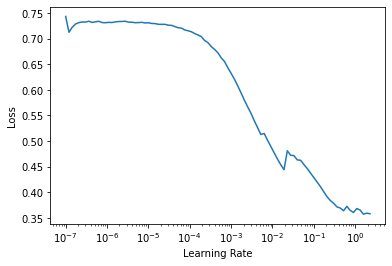

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.023657,0.033568,0.988335,0.945158,0.896019,02:00
1,0.025421,0.040854,0.983459,0.930845,0.870636,01:57
2,0.022890,0.017776,0.998637,0.965702,0.933679,02:00
3,0.015808,0.015129,0.997005,0.970777,0.943213,02:05
4,0.022336,0.015439,0.996650,0.971240,0.944087,01:59
5,0.015612,0.015375,0.997132,0.978365,0.957645,02:01


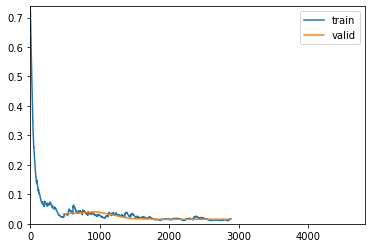

No improvement since epoch 3: early stopping


In [24]:
fname="deeplabv3-segmentron-resnet50-manual-spheroidj-data-augmentation-before-unfreeze-WD-2-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("deeplabv3-segmentron-resnet50-manual-spheroidj-data-augmentation-before-unfreeze-WD-2-best")
learn.validate()

(#4) [0.015129108913242817,0.9970049858093262,0.9707767590338666,0.9432130177342255]

Recorder

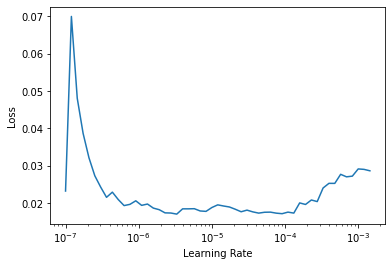

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.013457,0.017734,0.996338,0.966899,0.935919,02:24
1,0.014152,0.017109,0.996216,0.967433,0.936920,02:22
2,0.012228,0.015818,0.996419,0.970533,0.942753,02:22
3,0.013075,0.013487,0.997451,0.973893,0.949115,02:22
4,0.015469,0.015527,0.996732,0.970666,0.943004,02:22
5,0.013112,0.013946,0.996716,0.973562,0.948486,02:22


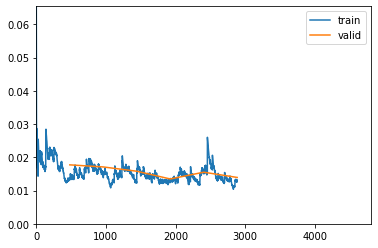

No improvement since epoch 3: early stopping


In [25]:
fname="deeplabv3-segmentron-resnet50-manual-spheroidj-data-augmentation-after-unfreeze-WD-2-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(2e-7,6e-7),cbs=callbacksFitAfterUnfreeze)

WD=1e-1

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[tumour, Dice(), JaccardCoeff()],wd=1e-1,
                                 splitter=segmentron_splitter).to_fp16()
learn.freeze() # Freezing the backbone

Recorder

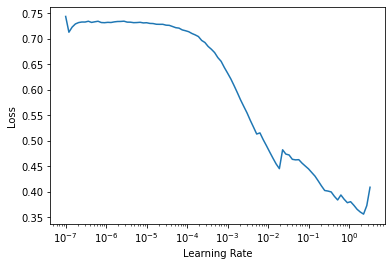

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.022726,0.049880,0.983231,0.921851,0.855031,01:58
1,0.028503,0.030887,0.989979,0.946710,0.898812,01:58
2,0.037654,0.029875,0.995999,0.945872,0.897303,01:58
3,0.028241,0.056725,0.980212,0.901432,0.820553,01:57
4,0.019826,0.013708,0.998169,0.976329,0.953752,01:57
5,0.018002,0.015445,0.995024,0.971704,0.944966,01:57
6,0.016954,0.011640,0.998241,0.977916,0.956786,01:57
7,0.012693,0.009961,0.998081,0.981478,0.963629,01:57
8,0.011100,0.009774,0.997949,0.981919,0.964481,01:58
9,0.008541,0.010016,0.998299,0.981540,0.963749,01:57


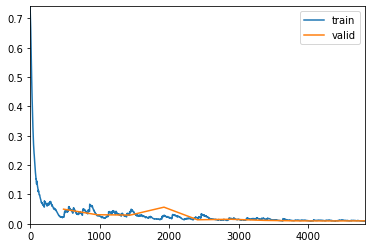

In [24]:
fname="deeplabv3-segmentron-resnet50-manual-spheroidj-data-augmentation-before-unfreeze-WD-1-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2),cbs=callbacksFitBeforeUnfreeze)

In [22]:
learn.load("deeplabv3-segmentron-resnet50-manual-spheroidj-data-augmentation-before-unfreeze-WD-1-best")
learn.validate()

(#4) [0.009774328209459782,0.9979491233825684,0.9819191583266347,0.9644805384145195]

Recorder

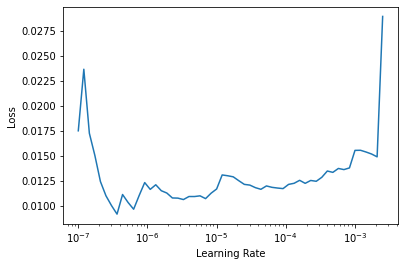

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.009291,0.010058,0.998084,0.981636,0.963934,02:21
1,0.010828,0.009956,0.997930,0.981699,0.964056,02:21
2,0.009519,0.009644,0.998102,0.982144,0.964914,02:21
3,0.010696,0.010090,0.998316,0.981400,0.963479,02:22
4,0.011757,0.009902,0.998220,0.981657,0.963974,02:22


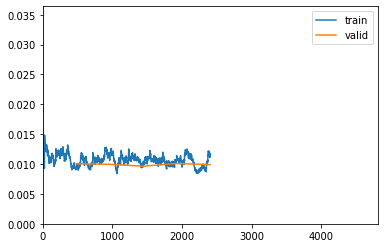

No improvement since epoch 2: early stopping


In [25]:
fname="deeplabv3-segmentron-resnet50-manual-spheroidj-data-augmentation-after-unfreeze-WD-1-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(2e-7,3e-7),cbs=callbacksFitAfterUnfreeze)

#### Evaluation - Best hyperparameters

Setting-up type transforms pipelines
Found 1435 items
2 datasets of sizes 1069,366
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/416.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/416.png
    applying <lambda> gives
      ../datasets/Labels/manual + spheroidj/416.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> SegmentationAlbumentationsTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pi

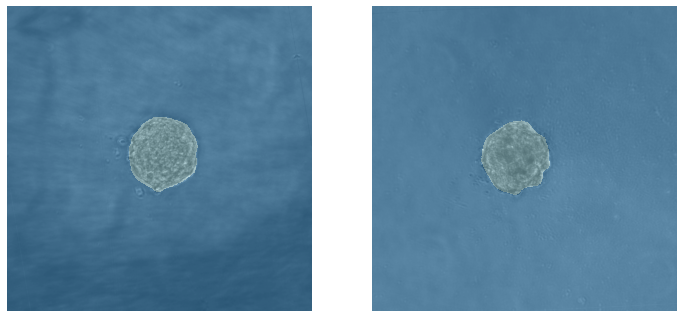

In [20]:
manual_spheroidj_clear = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_spheroidj_name,test_name]),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                  )
manual_spheroidj_clear.summary(path_images)
dls = manual_spheroidj_clear.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [21]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[tumour, Dice(), JaccardCoeff()],wd=1e-1,
                                 splitter=segmentron_splitter).to_fp16()
learn.freeze() # Freezing the backbone

Recorder

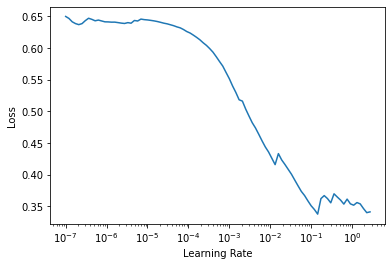

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.044658,0.036088,0.991940,0.942401,0.891077,02:36
1,0.035077,0.035965,0.991336,0.951746,0.907935,02:29
2,0.021341,0.017613,0.994558,0.967280,0.936633,02:29
3,0.014707,0.017924,0.997839,0.966958,0.936029,02:33
4,0.024425,0.041449,0.996076,0.935641,0.879066,02:32


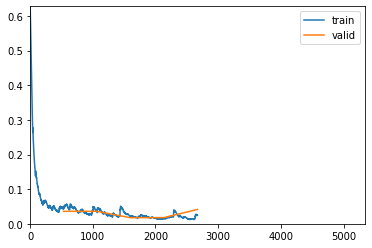

No improvement since epoch 2: early stopping


In [24]:
fname="deeplabv3-segmentron-resnet50-manual-spheroidj-data-augmentation-before-unfreeze-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-3,1e-2),cbs=callbacksFitBeforeUnfreeze)

In [23]:
learn.load("deeplabv3-segmentron-resnet50-manual-spheroidj-data-augmentation-before-unfreeze-best")
learn.validate()

(#4) [0.017612898722290993,0.994557797908783,0.9672797019664409,0.9366327976783974]

Recorder

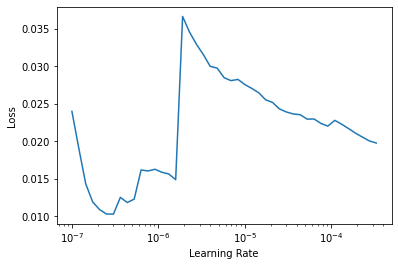

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.017960,0.020448,0.992626,0.962707,0.928096,03:01
1,0.016087,0.018466,0.993546,0.965563,0.933418,03:02
2,0.014772,0.017579,0.994656,0.967947,0.937885,03:03
3,0.014306,0.017250,0.995090,0.968855,0.939591,03:02
4,0.016141,0.017437,0.995279,0.969185,0.940213,03:02
5,0.014285,0.017630,0.995358,0.968704,0.939308,02:58
6,0.014620,0.017250,0.995736,0.970081,0.941900,02:53
7,0.015178,0.017347,0.995559,0.969730,0.941238,02:50
8,0.017593,0.017384,0.995801,0.969617,0.941026,03:00


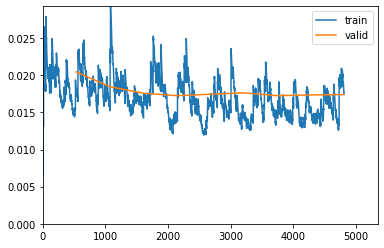

No improvement since epoch 6: early stopping


In [25]:
fname="deeplabv3-segmentron-resnet50-manual-spheroidj-data-augmentation-after-unfreeze-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-7,2e-7),cbs=callbacksFitAfterUnfreeze)

In [22]:
learn.load("deeplabv3-segmentron-resnet50-manual-spheroidj-data-augmentation-after-unfreeze-best")
learn.validate()

(#4) [0.01725035347044468,0.9957359433174133,0.9700806811328191,0.9418996841420753]

In [25]:
aux=learn.model
aux=aux.cpu()

traced_cell=torch.jit.script(aux)
traced_cell.save("TorchScript models/deeplabv3+-dataset3-data-augmentation.pth")

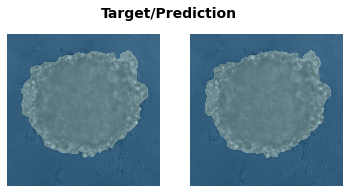

In [28]:
learn.show_results(vmin=0,vmax=1) # show results